In [53]:
from pathlib import Path
import random
import os
import warnings
# Ignore pandas deprecation warning
warnings.filterwarnings("ignore", "\nPyarrow", DeprecationWarning)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm.auto import tqdm

In [41]:
# BASE_PATH = Path("/kaggle/input/hms-harmful-brain-activity-classification")
BASE_PATH = Path("data/")
# SPEC_DIR = Path("/tmp/dataset/hms-hbac") # where to save the spectrograms after converting to numpy
SPEC_DIR = Path("data/spectrograms_npy")

class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label2name = dict(enumerate(class_names))
name2label = {v:k for k, v in label2name.items()}

## Get data

In [49]:
import utils.data_handling
utils.data_handling.BASE_PATH = BASE_PATH
utils.data_handling.SPEC_DIR = SPEC_DIR

from utils.data_handling import metadata_df, process_all_specs, create_spec_npy_dirs
# Run this to convert the spectrograms to .npy
if False:
    create_spec_npy_dirs()
    process_all_specs()
    
metadata = metadata_df("train")
metadata_test = metadata_df("test")
display(metadata.head(2))


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,0


## Visualize data

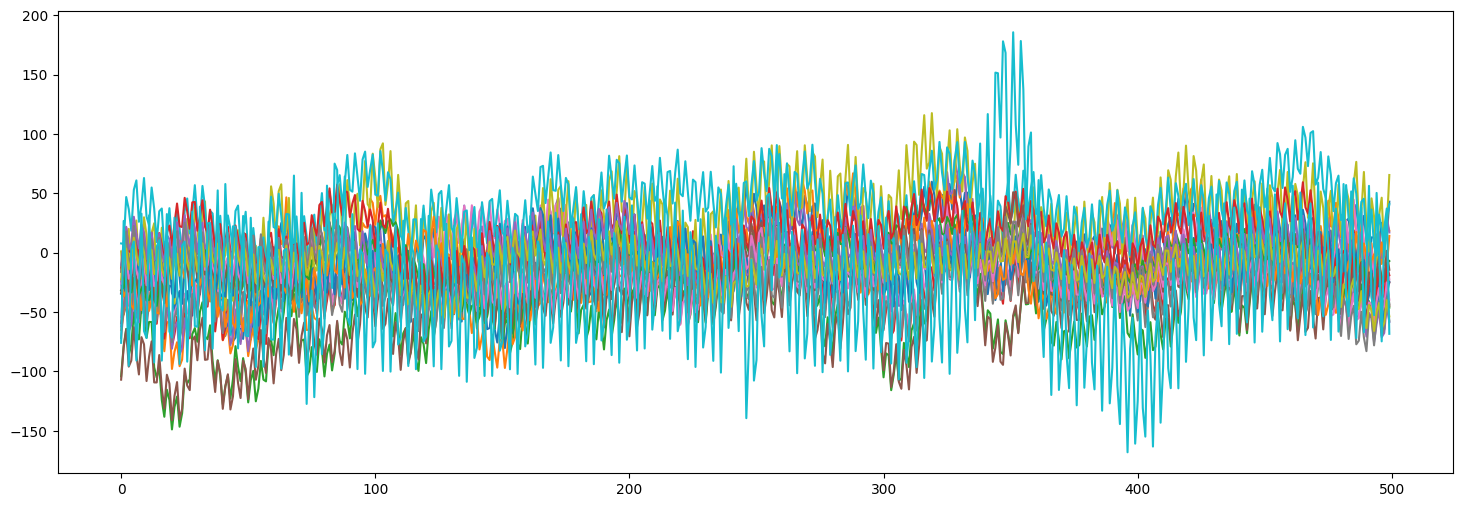

In [50]:
an_eeg = pd.read_parquet(metadata[metadata.expert_consensus == 'LPD'].iloc[0].eeg_path)
plt.figure(figsize=(18, 6))
plt.plot(an_eeg.iloc[:500]);

In [51]:
metadata.groupby("eeg_id").count()["eeg_sub_id"].value_counts()

eeg_sub_id
1      6324
2      1973
3      1430
4      1318
5       942
       ... 
101       1
85        1
236       1
210       1
226       1
Name: count, Length: 147, dtype: int64

In [54]:
idx = random.randint(0, len(metadata))
metadata.iloc[idx]

eeg_id                                                                     3786230730
eeg_sub_id                                                                          0
eeg_label_offset_seconds                                                          0.0
spectrogram_id                                                              877150942
spectrogram_sub_id                                                                  0
spectrogram_label_offset_seconds                                                  0.0
label_id                                                                    195387172
patient_id                                                                      49049
expert_consensus                                                                 GRDA
seizure_vote                                                                        0
lpd_vote                                                                            0
gpd_vote                                              

In [55]:
spec_parquet = pd.read_parquet(metadata.iloc[idx].spec_path)
spec_parquet.shape

(300, 401)

In [56]:
spec_parquet.columns[101:201]

Index(['RL_0.59', 'RL_0.78', 'RL_0.98', 'RL_1.17', 'RL_1.37', 'RL_1.56',
       'RL_1.76', 'RL_1.95', 'RL_2.15', 'RL_2.34', 'RL_2.54', 'RL_2.73',
       'RL_2.93', 'RL_3.13', 'RL_3.32', 'RL_3.52', 'RL_3.71', 'RL_3.91',
       'RL_4.1', 'RL_4.3', 'RL_4.49', 'RL_4.69', 'RL_4.88', 'RL_5.08',
       'RL_5.27', 'RL_5.47', 'RL_5.66', 'RL_5.86', 'RL_6.05', 'RL_6.25',
       'RL_6.45', 'RL_6.64', 'RL_6.84', 'RL_7.03', 'RL_7.23', 'RL_7.42',
       'RL_7.62', 'RL_7.81', 'RL_8.01', 'RL_8.2', 'RL_8.4', 'RL_8.59',
       'RL_8.79', 'RL_8.98', 'RL_9.18', 'RL_9.38', 'RL_9.57', 'RL_9.77',
       'RL_9.96', 'RL_10.16', 'RL_10.35', 'RL_10.55', 'RL_10.74', 'RL_10.94',
       'RL_11.13', 'RL_11.33', 'RL_11.52', 'RL_11.72', 'RL_11.91', 'RL_12.11',
       'RL_12.3', 'RL_12.5', 'RL_12.7', 'RL_12.89', 'RL_13.09', 'RL_13.28',
       'RL_13.48', 'RL_13.67', 'RL_13.87', 'RL_14.06', 'RL_14.26', 'RL_14.45',
       'RL_14.65', 'RL_14.84', 'RL_15.04', 'RL_15.23', 'RL_15.43', 'RL_15.63',
       'RL_15.82', 'RL_16.02'

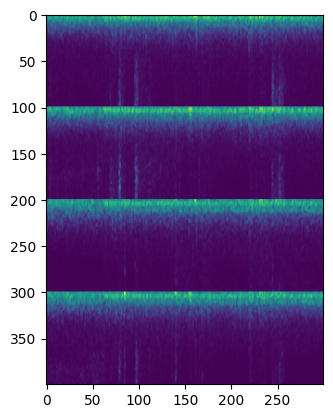

In [57]:
img = spec_parquet.iloc[:, 1:].values
img = np.log1p(img)
img = img.transpose()
img -= img.min()
img /= img.max() + 1e-4
plt.imshow(img)

In [58]:
metadata[metadata.eeg_id == metadata.iloc[idx].eeg_id]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,class_label
45371,3786230730,0,0.0,877150942,0,0.0,195387172,49049,GRDA,0,0,0,0,1,1,data/train_eegs/3786230730.parquet,data/train_spectrograms/877150942.parquet,data/spectrograms_npy/train_spectrograms/87715...,4
